# Volatility Forecasting: GARCH(3,3) vs. LLMAD Regression

This notebook compares the performance of two methods for forecasting 1-hour-ahead return volatility:

- A **GARCH(3,3)** model, a classic time series model capturing volatility clustering through 3 lags of past variances and residuals.
- A linear regression model using 3 lags of **LLMAD** — the *Log-Log Absolute Maximum Difference*, a proprietary volatility proxy

Forecast quality is assessed using Mean Squared Error (MSE), relative to both:
- Realized standard deviation of returns (standard devation of 1-minute returns over the course of 1 hour, then scaled to 1 hour)
- Absolute returns (a high-frequency proxy for volatility)

Results are calculated using a test set which is the last 25% of the data (non-shuffled)

In [2]:
import numpy as np
import pandas as pd
from arch import arch_model
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [3]:
# read in our data, which is 1-minute candles
df = pd.read_csv('btcdata.csv')
print(df.shape[0],'rows')
df.head(5)

308160 rows


,open,high,low,close,timestamp
0,67540.01,67585.89,67540.00,67573.41,2024-06-01 00:00:00
1,67573.41,67586.35,67561.40,67564.65,2024-06-01 00:01:00
2,67564.65,67582.90,67561.40,67582.90,2024-06-01 00:02:00
3,67582.90,67624.38,67582.89,67612.55,2024-06-01 00:03:00
4,67612.55,67655.00,67610.20,67647.88,2024-06-01 00:04:00


Create pertinent columns, and subset to appropriate 1-hour data

In [4]:
# Set timestamp index
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.index = df['timestamp']
df.index.name = 'timestamp_idx'

# 1-minute returns
df['return_1m'] = df['close'].pct_change()

# Rolling standard deviation of 1-min returns (time-aware)
std_1m = df['return_1m'].rolling('60min').std()
df['std_return_1h'] = std_1m * np.sqrt(60)  # Scale to 1-hour std dev

# Rolling high and low over past hour
df['high_1h'] = df['high'].rolling('60min').max()
df['low_1h'] = df['low'].rolling('60min').min()

# 1-hour return using 60-minute shift
df['return_1h'] = df['close'] / df['close'].shift(freq='60min') - 1

# a proxy for volatility which we will use later
# add 1e-12 to avoid log(0)
df['log_abs_ret_1h'] = np.log(np.abs(df['return_1h']) + 1e-12)

# 1-hour LLMAD 
log_diff = np.log(df['high_1h'])-np.log(df['low_1h'])
log_diff[log_diff <= 0.0] = 1e-12
llmad = np.log(log_diff)
df['llmad_1h'] = llmad

# Downsample to one row per hour
df_hourly = df.resample('1h').last().copy()
df_hourly = df_hourly.iloc[2:]


## GARCH
Run GARCH model; Note that the `arch` package used requires us to retrain for each forecast period

In [5]:
p=3
q=3
test_size=0.25

y = np.array(df_hourly['return_1h'])
y = y[~np.isnan(y)]
n = len(y)
split_idx = int(n * (1 - test_size))
test_len = n - split_idx

forecasts = []

# run GARCH for each period
for i in range(test_len):
    train_data = y[:split_idx + i] * 100  # scale to percent

    model = arch_model(train_data, vol='Garch', p=p, q=q, rescale=False)
    res = model.fit(disp='off')
    forecast = res.forecast(horizon=1)
    var = forecast.variance.values[-1, 0]
    forecasts.append(np.sqrt(var) / 100)  # scale back to decimal

garch_values = np.array(forecasts)

## LLMAD regression

Create lags of LLMAD features

In [6]:
for lag in [1,2,3]:
    df_hourly['llmad_1h_lag'+str(lag)] = df_hourly['llmad_1h'].shift(freq=str(lag*60)+'min')
reg_cols = ['llmad_1h_lag'+str(lag) for lag in [1,2,3] ]
df_hourly['log_std_1h'] = np.log(df_hourly['std_return_1h'])

run simple linear regression using LLMAD lag features, note that this is a single, time-invariant model
(which is faster and has much lower compute requirement than the above implementation of GARCH)

In [7]:
target = 'log_std_1h'
traindf = df_hourly[[target]+reg_cols].iloc[:split_idx].dropna()
testdf = df_hourly[reg_cols].iloc[split_idx:]
lm = LinearRegression().fit(np.array(traindf[reg_cols]),np.array(traindf[target]))
lm_values = np.exp(lm.predict(np.array(testdf[reg_cols])))

## Comparison of GARCH vs LLMAD regression

As seen in the metrics below as well as plot visualizations, the LLMAD regression outperforms GARCH in essentially
every way, in addition to the model parameters used being time invarient (the way we impelemented GARCH was *not*)
which allows much faster and simpler compute time.

In [10]:
std = df_hourly['std_return_1h'].iloc[split_idx:]
abs_ret = df_hourly['abs_ret_1h'].iloc[split_idx:]

mse_data = {
    'Metric': [
        'log(std dev)',
        'std dev',
        'log(abs ret)',
        'abs ret'
    ],
    'GARCH MSE': [
        mean_squared_error(np.log(std), np.log(garch_values)),
        mean_squared_error(std, garch_values),
        mean_squared_error(np.log(abs_ret), np.log(garch_values)),
        mean_squared_error(abs_ret, garch_values)
    ],
    'LLMAD reg MSE': [
        mean_squared_error(np.log(std), np.log(lm_values)),
        mean_squared_error(std, lm_values),
        mean_squared_error(np.log(abs_ret), np.log(lm_values)),
        mean_squared_error(abs_ret, lm_values)
    ]
}

mse_df = pd.DataFrame(mse_data)
mse_df.set_index('Metric', inplace=True)
mse_df

,GARCH MSE,LLMAD reg MSE
Metric,,
log(std dev),0.151956,0.104030
std dev,0.000006,0.000005
log(abs ret),1.887026,1.572389
abs ret,0.000020,0.000017


For visualization we use log($\sigma$) because $\sigma$ has a very heavily right skewed distribution,
log transforming produces a near-gaussian distribution which is both useful for visualizing and assessing
performance

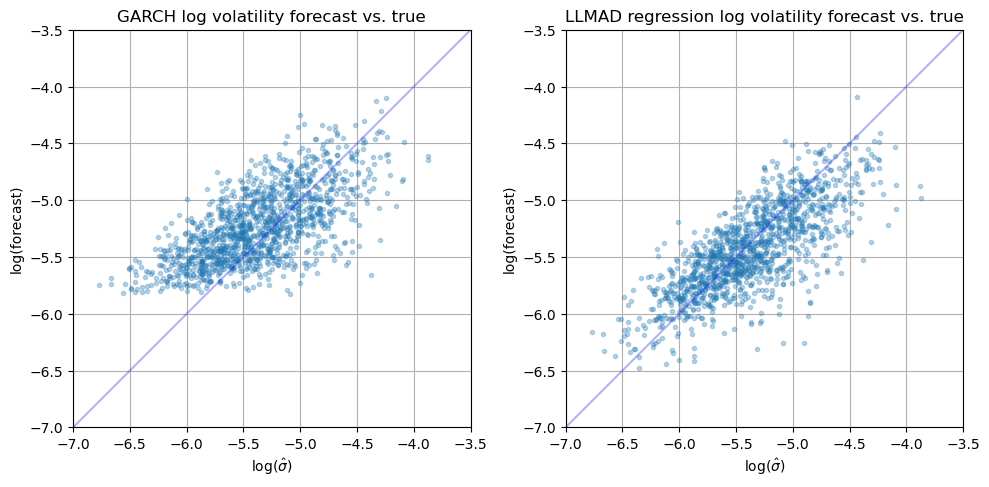

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))  

# GARCH plot
axes[0].plot(np.log(df_hourly['std_return_1h'].iloc[split_idx:]), np.log(garch_values), '.', alpha=0.3)
axes[0].plot([-7, -3], [-7, -3], color='blue', alpha=0.3)
axes[0].set_xlim(-7, -3.5)
axes[0].set_ylim(-7, -3.5)
axes[0].set_xlabel('log($\\hat{\\sigma}$)')
axes[0].set_ylabel('log(forecast)')
axes[0].set_title('GARCH log volatility forecast vs. true')
axes[0].grid(True)
axes[0].set_aspect('equal', adjustable='box')

# LLMAD plot
axes[1].plot(np.log(df_hourly['std_return_1h'].iloc[split_idx:]), np.log(lm_values), '.', alpha=0.3)
axes[1].plot([-7, -3], [-7, -3], color='blue', alpha=0.3)
axes[1].set_xlim(-7, -3.5)
axes[1].set_ylim(-7, -3.5)
axes[1].set_xlabel('log($\\hat{\\sigma}$)')
axes[1].set_ylabel('log(forecast)')
axes[1].set_title('LLMAD regression log volatility forecast vs. true')
axes[1].grid(True)
axes[1].set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.savefig('forecast v true plots.png')
plt.show()